# The reparametrized Mandel & Agol (2002) $\Lambda$ function

#### Validation of the stable version of the $\Lambda$ function for linearly limb-darkened transits

Let's import some stuff and define the numerical integral of a linearly limb-darkened source. We use scipy's `dblquad` function to compute the integral of $\sqrt{1 - x^2 - y^2}$ over the unocculted region of the source.

In [1]:
import numpy as np
from mpmath import ellipe, ellipk, ellippi
import matplotlib.pyplot as pl
from scipy.integrate import dblquad, quad
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

def NumericalFlux(b, r):
    """Compute the flux by numerical integration of the surface integral."""
    # I'm only coding up a specific case here
    b = np.abs(b)
    if b >= 1 + r:
        return 2 * np.pi / 3
    elif b <= r - 1:
        return 0

    # Total flux
    total = (np.pi / 6) * (6 - 2)
    if b >= 1 + r:
        return total

    # Get points of intersection
    if b > 1 - r:
        yi = (1. + b ** 2 - r ** 2) / (2. * b)
        xi = (1. / (2. * b)) * np.sqrt(4 * b ** 2 - (1 + b ** 2 - r ** 2) ** 2)
    else:
        yi = np.inf
        xi = r

    # Specific intensity map
    def I(y, x):
        return np.sqrt(1 - x ** 2 - y ** 2)

    # Lower integration limit
    def y1(x):
        if yi <= b:
            # Lower occultor boundary
            return b - np.sqrt(r ** 2 - x ** 2)
        elif b <= 1 - r:
            # Lower occultor boundary
            return b - np.sqrt(r ** 2 - x ** 2)
        else:
            # Tricky: we need to do this in two parts
            return b - np.sqrt(r ** 2 - x ** 2)

    # Upper integration limit
    def y2(x):
        if yi <= b:
            # Upper occulted boundary
            return np.sqrt(1 - x ** 2)
        elif b <= 1 - r:
            # Upper occultor boundary
            return b + np.sqrt(r ** 2 - x ** 2)
        else:
            # Tricky: we need to do this in two parts
            return np.sqrt(1 - x ** 2)

    # Compute the total flux
    flux, _ = dblquad(I, -xi, xi, y1, y2, epsabs=1e-14, epsrel=1e-14)

    # Do we need to solve an additional integral?
    if not (yi <= b) and not (b <= 1 - r):

        def y1(x):
            return b - np.sqrt(r ** 2 - x ** 2)

        def y2(x):
            return b + np.sqrt(r ** 2 - x ** 2)

        additional_flux, _ = dblquad(I, -r, -xi, y1, y2,
                                     epsabs=1e-14, epsrel=1e-14)

        flux += 2 * additional_flux

    return total - flux

Now we define the analytic functions in the paper. We're computing the elliptic integral `cel` the slow way: by direct integration. In `starry` and `limbdark`, we employ the fast technique from Bulirsch (1969) to do this.

In [2]:
def cel(kc, p, a, b):
    """The Bulirsch `cel` elliptic integral"""
    def integrand(phi):
        cos2 = np.cos(phi) ** 2
        sin2 = 1 - cos2
        return (a * cos2 + b * sin2) / ((cos2 + p * sin2) * np.sqrt(cos2 + kc ** 2 * sin2))
    res, _ = quad(integrand, 0, np.pi / 2, epsabs=1e-14, epsrel=1e-14)
    return res

def S1(b, r):
    """The flux during the occultation."""
    b = np.abs(b)
    if b >= 1 + r:
        return 2 * np.pi / 3
    elif b <= r - 1:
        return 0
    return 2 * np.pi / 3 * (1 - 3 * Lambda(b, r) / 2 - int(r > b))


def Lambda(b, r):
    """The reparametrized Mandel & Agol (2002) Lambda function."""
    ksq = (1 - r ** 2 - b ** 2 + 2 * b * r) / (4 * b * r)
    if ksq < 1:
        mk = ksq
        kc = np.sqrt(1 - mk)
    else:
        mk = 1 / ksq
        kc = np.sqrt(1 - mk)
        
    if (r == 0):
        return 0
    elif np.abs(r - b) >= 1:
        return 0
    elif b == 0:
        return -2. / 3. * (1 - r ** 2) ** 1.5
    elif b == r and r == 0.5:
        return 1. / 3. - 4. / (9 * np.pi)
    elif b == r and r < 0.5:
        return 1. / 3. + 2. / (9 * np.pi) * cel(kc, 1, mk - 3, (1 - mk) * (2 * mk - 3))
    elif b == r and r > 0.5:
        return 1. / 3. + 1. / (9 * np.pi * r) * cel(kc, 1, mk - 3, 1 - mk)
    elif b + r == 1:
        return 2 / (9 * np.pi) * (3 * np.arccos(1 - 2 * r) - 2 * (3 + 2 * r - 8 * r ** 2) * np.sqrt(r * b) - 3 * np.pi * int(r > 0.5))
    elif ksq < 1:
        f1 = (1 - (b - r) ** 2) / (9 * np.pi * np.sqrt(b * r))
        f2 = ((b + r) ** 2 - 1) / (4 * b * r) * (b ** 2 - r ** 2)
        f3 = 3 - 6 * r ** 2 - 2 * b * r
        cel1 = cel(kc, (b - r) ** 2 * (1 - mk), 0, 3)
        cel2 = cel(kc, 1, 1, 0)
        E = float(ellipe(mk))
        return f1 * (f2 * cel1 - f3 * cel2 - 4 * b * r * E)
    else:
        f1 = 2. * np.sqrt(1 - (b - r) ** 2) / (9 * np.pi)
        f2 = 1 - (r + b) ** 2
        f3 = 4 - 7 * r ** 2 - b ** 2
        p = ((b - r) / (b + r)) ** 2 * (1 - (b + r) ** 2) / (1 - (b - r) ** 2)
        q = 3 * (b - r) / ((b + r) * (1 - (b - r) ** 2))
        cel1 = cel(kc, p, 1 + q, p + q)
        E = float(ellipe(mk))
        return f1 * (f2 * cel1 - f3 * E)

## Let's compare the two expressions for a simple transit:

In [3]:
r = 0.1
b = np.linspace(-1.5, 1.5, 100)
sol1 = np.array([NumericalFlux(b[i], r) for i in range(100)])
sol2 = np.array([S1(b[i], r) for i in range(100)])

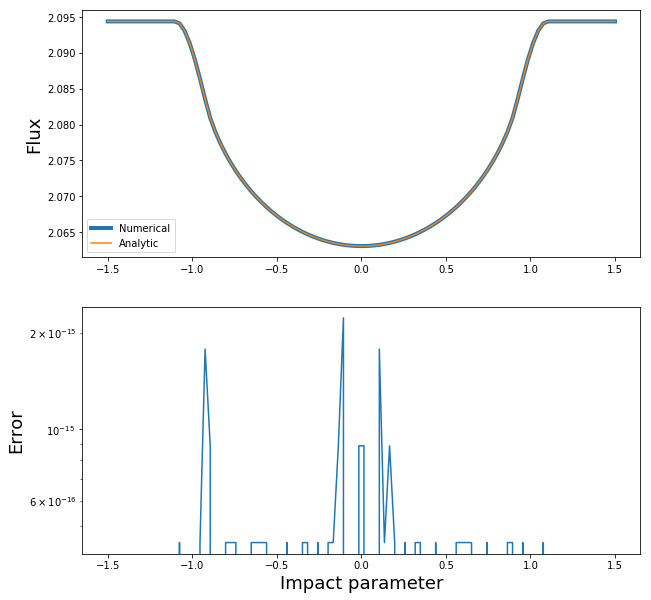

In [4]:
fig, ax = pl.subplots(2, figsize=(10, 10))
ax[0].plot(b, sol1, lw=4, label='Numerical')
ax[0].plot(b, sol2, label='Analytic')
ax[1].plot(b, np.abs(sol1 - sol2))
ax[1].set_yscale('log')
ax[0].legend();
ax[1].set_xlabel('Impact parameter', fontsize=18);
ax[0].set_ylabel('Flux', fontsize=18);
ax[1].set_ylabel('Error', fontsize=18);

Note that the error is mostly due to the numerical integration!

## Let's compare the expressions at the singular points:

### r = 0

In [5]:
b = 0.2
r = 0
print(NumericalFlux(b, r), S1(b, r))

2.0943951023931953 2.0943951023931953


### |r - b| $\ge$ 1

In [6]:
b = 3.4
r = 5.2
print(NumericalFlux(b, r), S1(b, r))

0 0


### b = 0

In [12]:
b = 0
r = 0.5
print(NumericalFlux(b, r))
print(S1(b, r))

1.3603495231756622
1.3603495231756633


### b = r = $\frac{1}{2}$ 

In [13]:
b = 0.5
r = 0.5
print(NumericalFlux(b, r))
print(S1(b, r))

1.4916419956410423
1.4916419956410423


### b = r < $\frac{1}{2}$ 

In [14]:
b = 0.3
r = 0.3
print(NumericalFlux(b, r))
print(S1(b, r))

1.8318266845134275
1.8318266845134277


### b = r > $\frac{1}{2}$ 

In [21]:
b = 0.8
r = 0.8
print(NumericalFlux(b, r))
print(S1(b, r))

1.3016816564752158
1.268746981210184


### b + r = 1

In [16]:
b = 0.75
r = 0.25
print(NumericalFlux(b, r))
print(S1(b, r))

1.9736136707850893
1.973613670785089
